In [ ]:
from google.colab import files
files.upload()

In [ ]:
torch.cuda.device_count()

In [1]:
#!pip install pyroomacoustics
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from room_simulation import Simulation
from sine_dataset import SineData
from network import SSLConvNet as ConvNet
from network import SSLConvNetCosLoss as ConvNetCosLoss
from logger import Logger
import matplotlib.pyplot as plt
import math
import seaborn as sns

# Important paramters for training DNN
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)
EPOCHS = 7000
BATCH_SIZE = 32
STEP_SIZE = 10

# Important simulation and data constants
NR_MICS = 2                                         # Number of mircophones in simulation
RAD = 50                                         # Radius of ellipse of microphone placements in cm
RADII = [50, 500, 5000]
ROOM_SIMS = []
DATASETS = []
MIC_L_DIST = (11, -10)                         # Distance between center and left microphone in cm on x-axis
MIC_R_DIST = (11, -10)                  # Distance between center and right microphone in cm on y-axis
# Absorption factor of the room in the simulation (1 = no reverb)
ABSORPTION = 0.0
# Minimal frequency of a sine wave according to Nyquist theorem
MAX_FREQ = 20000
SAMPLE_RATE = int(MAX_FREQ*2.2)                            # Sampling rate of signals in Hz
TIME = 1                                            # Time in seconds of sine wave
# MIN_LENGTH = SAMPLE_RATE*TIME + int(TIME*MAX_FREQ*0.2)                                  # Length a single sine signal should have
MIN_LENGTH = 65000
MIN_LENGTH_MSECOS = 48000
TO_RAD = np.pi/180                                  # Constant to convert degrees to radians
TO_DEG = 180/np.pi                                  # Constant to convert radians to degrees
print(MIN_LENGTH)

for rad in RADII:
  roomSim = Simulation(SAMPLE_RATE, rad, ABSORPTION, MIC_L_DIST, MIC_R_DIST, NR_MICS)
  ROOM_SIMS.append(roomSim)

  DATASETS.append(SineData(BATCH_SIZE, roomSim, TIME, MIN_LENGTH, 20, MAX_FREQ))




cuda:2
65000


In [ ]:
# # Plot room
# roomSim.plotRoom()

# Define custom loss function
class CosBorderLoss(torch.nn.Module):

    def __init__(self):
        super(CosBorderLoss, self).__init__()

    def forward(self, pred, target):
        radial = torch.abs(torch.cos(pred-target) - torch.cos(target-target))
        border = nn.functional.relu(pred-2*np.pi) + nn.functional.relu(-pred)
        return torch.sum(radial + border)

# Plot heatmap of custom loss function
# criterion = CosBorderLoss()
# cos_border_loss = np.zeros((360,360))
# i = 0
# j = 0
# for deg1 in np.arange(360):#(-360,720):
#     for deg2 in np.arange(360):  # (-360, 720):
#         rad1 = torch.as_tensor(deg1*TO_RAD)
#         rad2 = torch.as_tensor(deg2*TO_RAD)
#         cos_border_loss[i, j] = criterion(rad1, rad2)
#         j += 1
#     j = 0
#     i += 1
# ax = sns.heatmap(cos_border_loss)
# plt.title("Heatmap of loss function based on cos + border")
# plt.xlabel("Angles in degrees (should be range [-2pi,4pi])")
# plt.ylabel("Angles in degrees (should be range [-2pi,4pi])")
# plt.show()


In [ ]:
# Initialize network and train parameters
# torch.cuda.empty_cache()
if EPOCHS > 0:
    for i in range(len(RADII)):
        print("----------- MODEL " + str(i) + " -----------")
        print("Rad = "+str(RADII[i]))
        net = ConvNet(DATASETS[i].MIN_LENGTH)
        net = net.double().to(device)
        criterion = nn.MSELoss()
        optimiser = torch.optim.Adam(net.parameters())
        logger = Logger("./logs", "RAD" + str(RADII[i]))
        dataLoader = DataLoader(DATASETS[i], batch_size=BATCH_SIZE)

        for curEpoch in range(EPOCHS):
            # Reset seed so random sine data is generated, otherwise RNG is repeated
            np.random.seed()

            # Gather input data & labels
            inL, inR, labelX, labelY, _ = next(iter(dataLoader))
            inL = inL.double().to(device)
            inR = inR.double().to(device)
            labelX = labelX.double().to(device)
            labelY = labelY.double().to(device)

            # Training loop
            optimiser.zero_grad()
            outputX, outputY = net(inL, inR, debug = False)
            outputX = torch.squeeze(outputX)
            outputY = torch.squeeze(outputY)
            loss = criterion(outputX, labelX) + criterion(outputY, labelY)
            loss.backward()
            optimiser.step()

            if curEpoch % STEP_SIZE == 0: 
                # Log loss in tensorboard as scalars
                logger.scalar_summary("loss", loss.item(), curEpoch)

                outputXnp = outputX.detach().cpu().numpy()
                outputYnp = outputY.detach().cpu().numpy()
                labelXnp = labelX.detach().cpu().numpy()
                labelYnp = labelY.detach().cpu().numpy()

                # Plot the predicted vs actual angles
                if curEpoch % 100 == 0:
                    print("Loss of epoch "+str(curEpoch)+" = "+str(loss.item()))
                    
                    plt.scatter(labelXnp, outputXnp, c="red", label = "X")
                    plt.scatter(labelYnp, outputYnp, c="blue", label = "Y")
                    plt.title("Pred X (red) and Y (blue) coords vs actual coords of epoch " + str(curEpoch) + " of radius = " + str(RADII[i]))
                    plt.xlabel("Actual X/Y values")
                    plt.ylabel("Predicted X/Y values")
                    plt.legend()
                    plt.show()

                # Log gradients and weights in tensorboard as distributions and histograms
                for tag, value in net.named_parameters():
                    tag = tag.replace('.', '/')
                    logger.histo_summary(tag, value.data.cpu().numpy(), curEpoch)
                    logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), curEpoch)

                    # Log gradient of last layer as scalar
                    if "fc" in tag and "weight" in tag:
                        last_grad_norm = np.sqrt(np.mean(np.square(value.grad.data.cpu().numpy())))
                        logger.scalar_summary("last_grad_norm", last_grad_norm, curEpoch)

            curEpoch += 1

        del net, inL, inR, labelX, labelY
            
        torch.save(net.state_dict(), "ConvNet_Rad" + str(RADII[i]))



In [ ]:
roomSim = Simulation(SAMPLE_RATE, RAD, ABSORPTION, MIC_L_DIST, MIC_R_DIST, NR_MICS)
dataset = SineData(BATCH_SIZE, roomSim, TIME, MIN_LENGTH_MSECOS, MAX_FREQ)

if EPOCHS > 0:
    net = ConvNet(MIN_LENGTH)
    net = net.double().to(device)
    criterion = nn.MSELoss()
    optimiser = torch.optim.Adam(net.parameters())
    logger = Logger("./logs", "MSE")
    dataLoader = DataLoader(dataset, batch_size=BATCH_SIZE)

    for curEpoch in range(EPOCHS):
        # Reset seed so random sine data is generated, otherwise RNG is repeated
        np.random.seed()

        # Gather input data & labels
        inL, inR, labelX, labelY, _ = next(iter(dataLoader))
#         inL, inR, _, _, labelAzi = next(iter(dataLoader))
        inL = inL.double().to(device)
        inR = inR.double().to(device)
#         labelAzi = labelAzi.double().to(device)
        labelX = labelX.double().to(device)
        labelY = labelY.double().to(device)

        # Training loop
        optimiser.zero_grad()
        outputX, outputY = net(inL, inR, debug = False)
        loss = criterion(torch.squeeze(outputX), labelX) + criterion(torch.squeeze(outputY), labelY)
        loss.backward()
        optimiser.step()

        if curEpoch % STEP_SIZE == 0: 
            # Log loss in tensorboard as scalars
            logger.scalar_summary("loss", loss.item(), curEpoch)

            outputXnp = outputX.detach().cpu().numpy()
            outputYnp = outputY.detach().cpu().numpy()
            labelXnp = labelX.detach().cpu().numpy()
            labelYnp = labelY.detach().cpu().numpy()

            # Plot the predicted vs actual angles
            if curEpoch % 100 == 0:
                print("Loss of epoch "+str(curEpoch)+" = "+str(loss.item()))
                
                plt.scatter(labelXnp, outputXnp, c="red", label = "X")
                plt.title("Pred X (red) and Y (blue) coords vs actual coords of epoch " + str(curEpoch) + " of radius = " + str(RADII[i]))
                plt.xlabel("Actual X/Y values")
                plt.ylabel("Predicted X/Y values")
                plt.legend()
                plt.show()

                plt.scatter(labelYnp, outputYnp, c="blue", label = "Y")
                plt.title("Pred X (red) and Y (blue) coords vs actual coords of epoch " + str(curEpoch) + " of radius = " + str(RADII[i]))
                plt.xlabel("Actual X/Y values")
                plt.ylabel("Predicted X/Y values")
                plt.legend()
                plt.show()
#                 plt.scatter(labelAzinp, outputnp)
#                 plt.title("Pred azi vs actual azi of epoch "+str(curEpoch)+" of radius = "+str(RAD))
#                 plt.xlabel("Actual azi")
#                 plt.ylabel("Predic azi")
#                 plt.show()

            # Log gradients and weights in tensorboard as distributions and histograms
            for tag, value in net.named_parameters():
                tag = tag.replace('.', '/')
                logger.histo_summary(tag, value.data.cpu().numpy(), curEpoch)
                logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), curEpoch)

                # Log gradient of last layer as scalar
                if "fc" in tag and "weight" in tag:
                    last_grad_norm = np.sqrt(np.mean(np.square(value.grad.data.cpu().numpy())))
                    logger.scalar_summary("last_grad_norm", last_grad_norm, curEpoch)

        curEpoch += 1

    torch.save(net.state_dict(), "ConvNet_CosLoss")



Loss of epoch 0 = 7957.640571440108


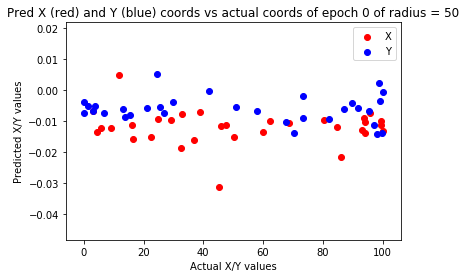

Loss of epoch 100 = 7515.805956473984


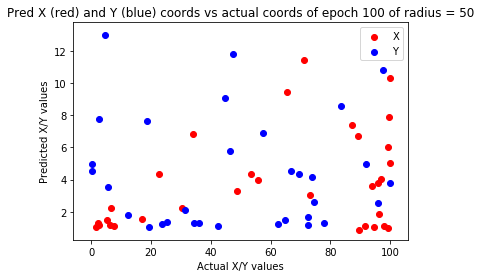

Loss of epoch 200 = 7117.840400576444


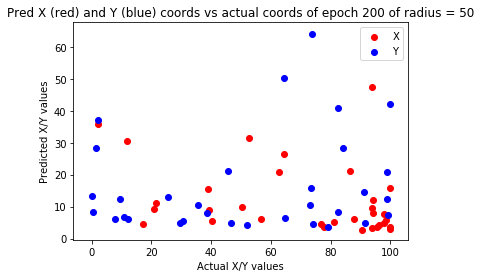

Loss of epoch 300 = 6308.083193721412


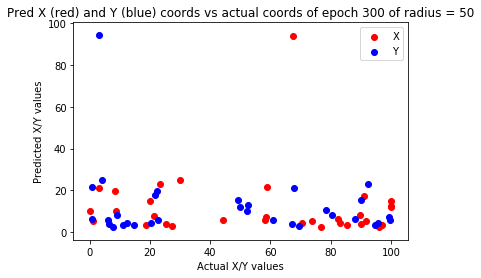

Loss of epoch 400 = 7441.103283472147


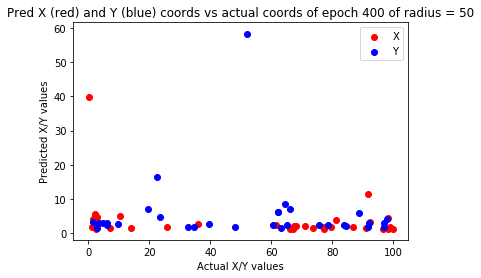

Loss of epoch 500 = 8873.872733837292


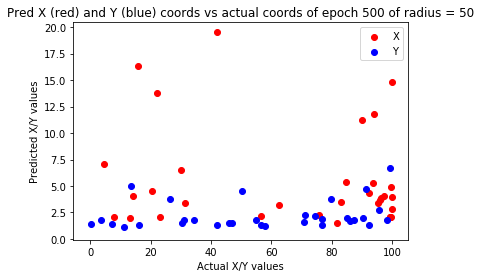

Loss of epoch 600 = 5382.670631340429


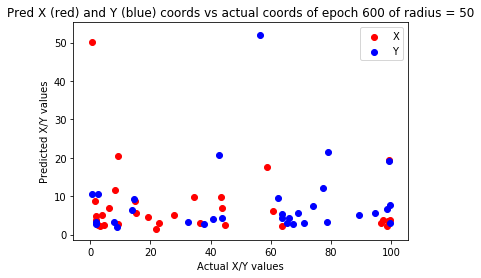

Loss of epoch 700 = 6008.1167365994115


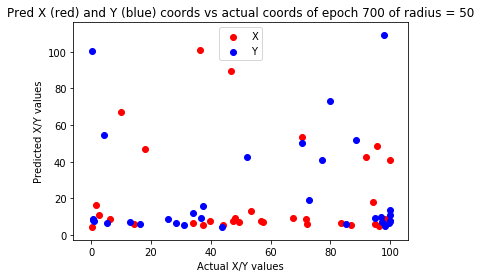

Loss of epoch 800 = 4458.59350473712


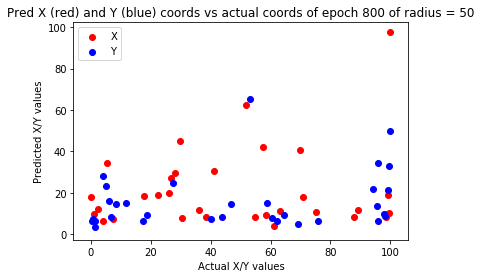

Loss of epoch 900 = 4232.323444355918


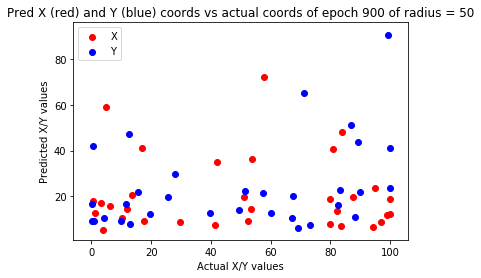

Loss of epoch 1000 = 4684.315900465225


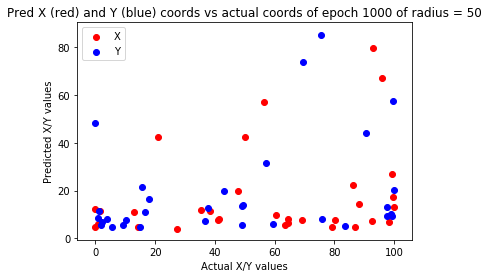

Loss of epoch 1100 = 4662.8069400904515


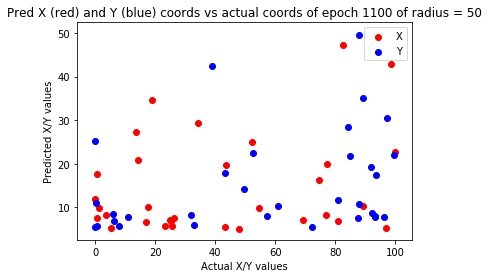

Loss of epoch 1200 = 2938.8022347079914


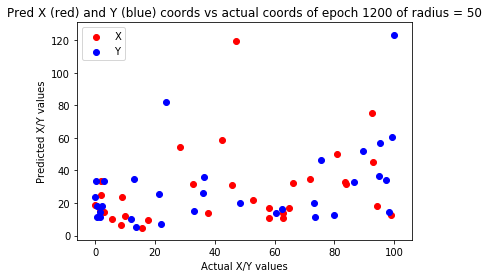

Loss of epoch 1300 = 6074.591998023319


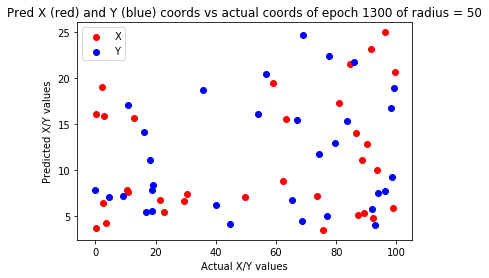

Loss of epoch 1400 = 4548.061323547434


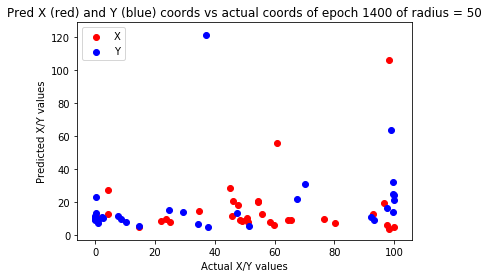

Loss of epoch 1500 = 3772.7015146453855


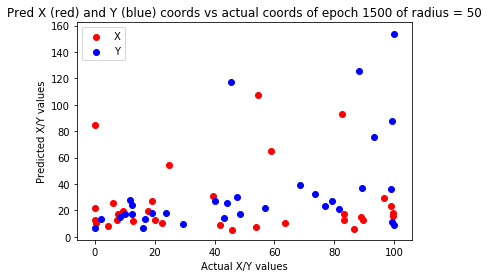

Loss of epoch 1600 = 3689.910807417968


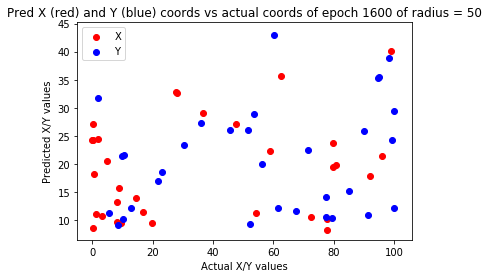

Loss of epoch 1700 = 3756.5784877515553


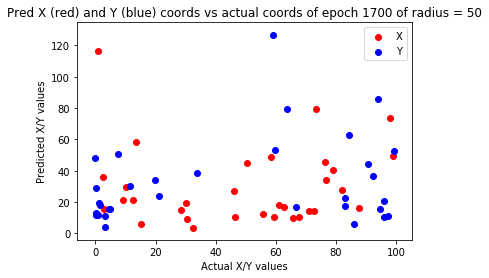

Loss of epoch 1800 = 4072.3585570975783


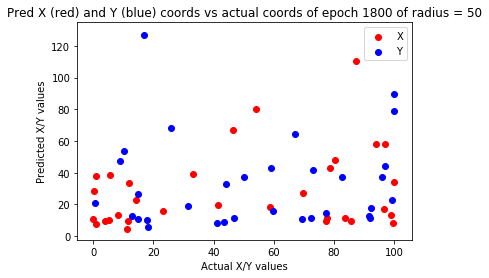

Loss of epoch 1900 = 3679.6914530399317


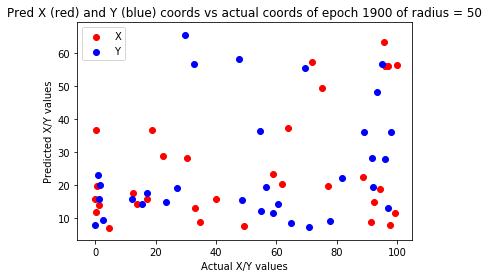

Loss of epoch 2000 = 5256.632227402673


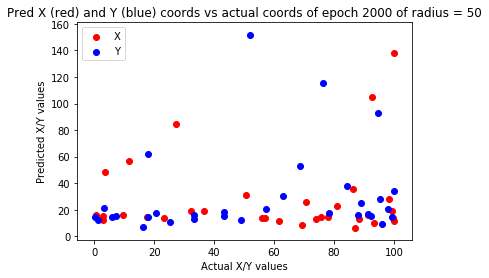

Loss of epoch 2100 = 5260.469562300266


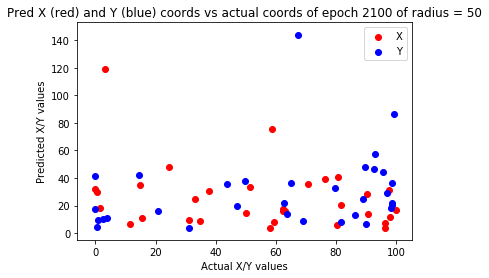

Loss of epoch 2200 = 3305.068980618747


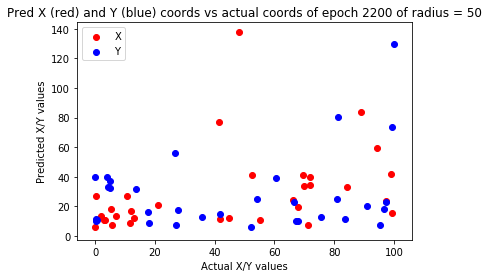

Loss of epoch 2300 = 4261.495743880906


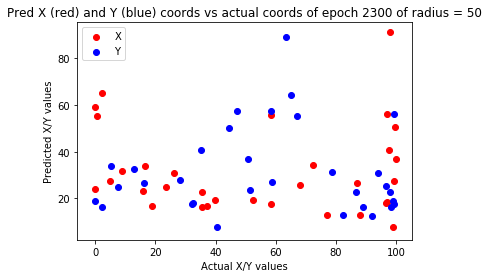

Loss of epoch 2400 = 4543.657788817304


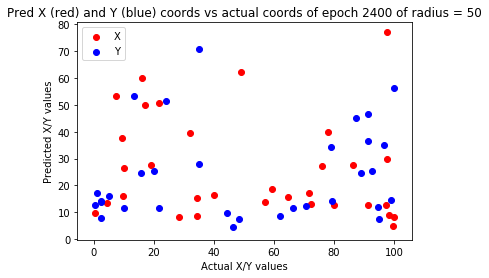

Loss of epoch 2500 = 3579.0719718049254


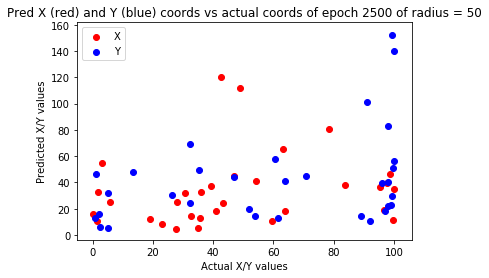

Loss of epoch 2600 = 4842.442273247869


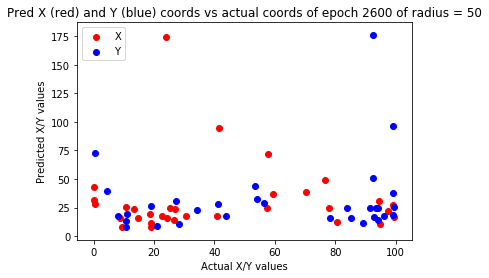

Loss of epoch 2700 = 4058.7784086636807


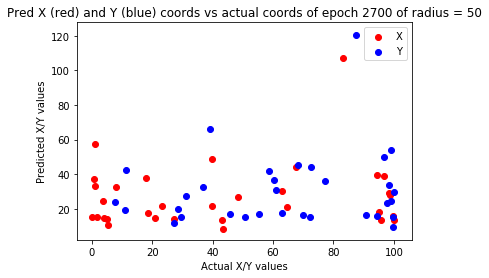

Loss of epoch 2800 = 4502.048527056467


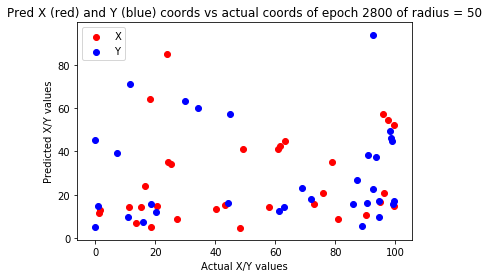

Loss of epoch 2900 = 4264.764710551736


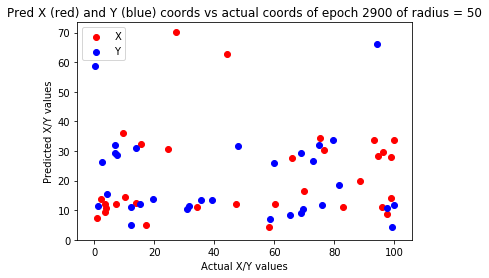

Loss of epoch 3000 = 3855.3395795360548


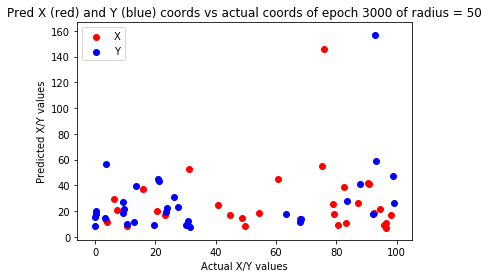

Loss of epoch 3100 = 5511.593184283285


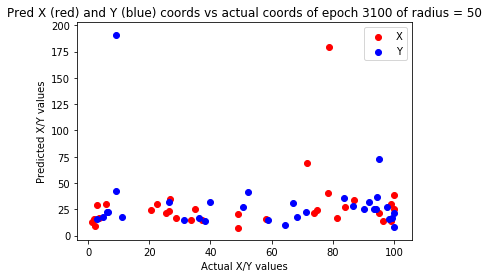

Loss of epoch 3200 = 3525.0410551371497


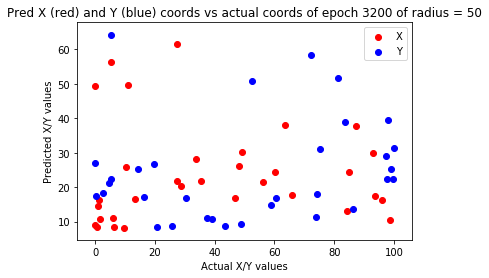

Loss of epoch 3300 = 4548.7448606503895


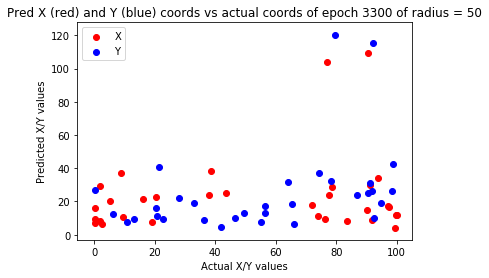

Loss of epoch 3400 = 6179.524216230413


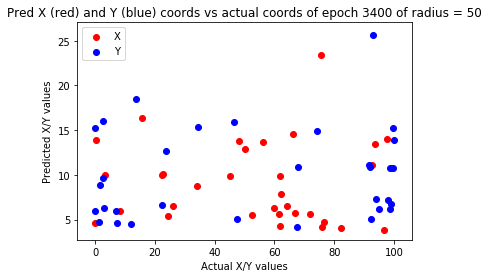

Loss of epoch 3500 = 4334.785524390841


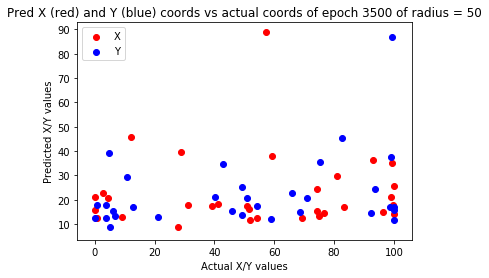

Loss of epoch 3600 = 3703.617902660412


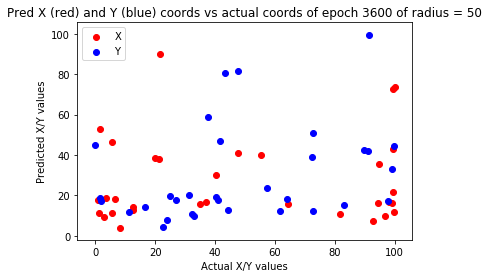

Loss of epoch 3700 = 5077.737841115267


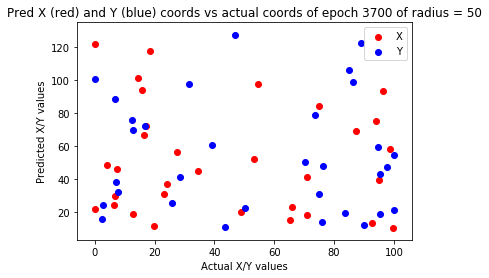

Loss of epoch 3800 = 4891.946534764418


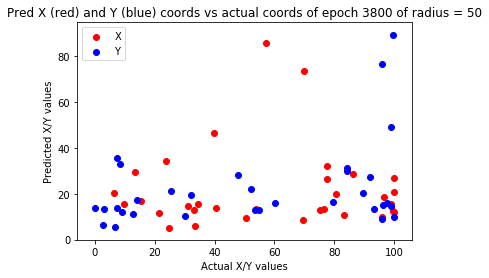

Loss of epoch 3900 = 3170.8544382891846


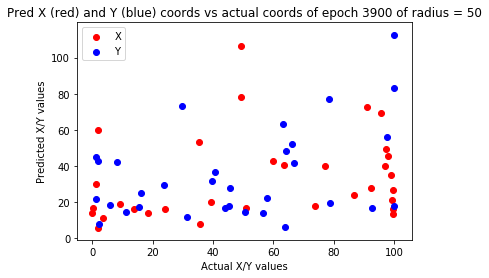

Loss of epoch 4000 = 2446.592452765016


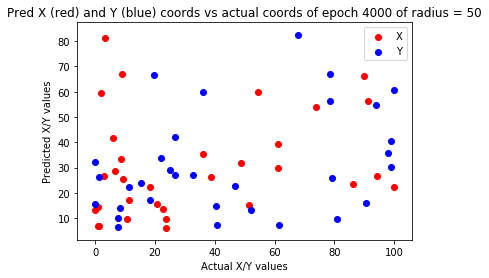

Loss of epoch 4100 = 5916.934941227289


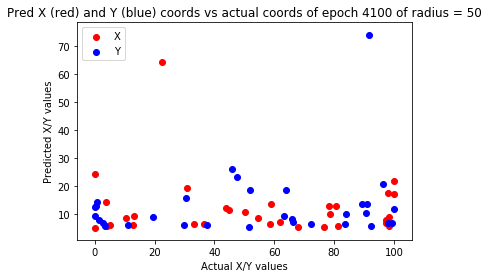

Loss of epoch 4200 = 3612.5203865971303


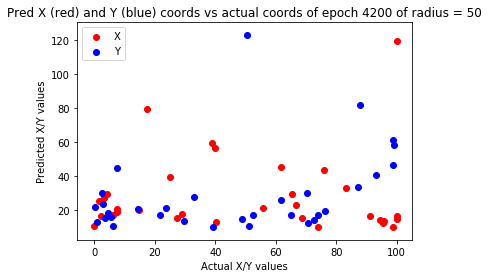

Loss of epoch 4300 = 3508.319486444904


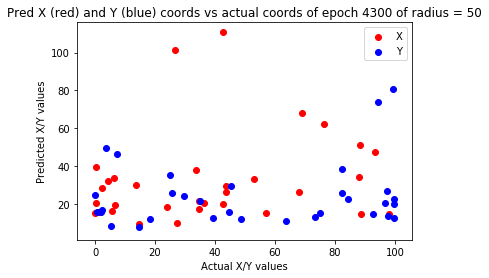

Loss of epoch 4400 = 4321.59719951423


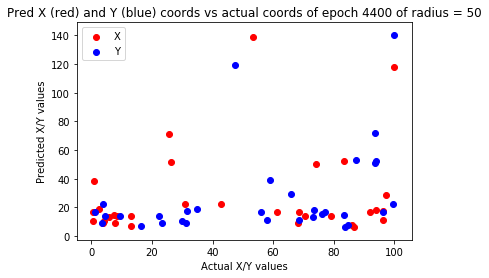

Loss of epoch 4500 = 3719.811614116587


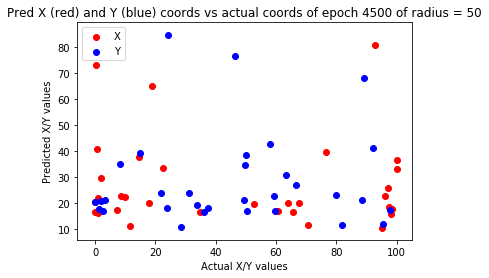

Loss of epoch 4600 = 4855.311042093442


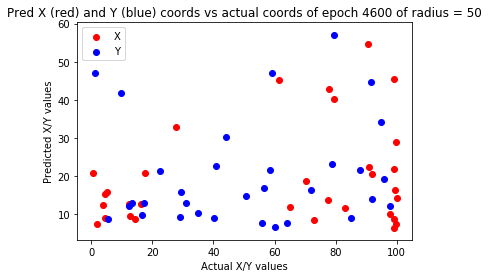

Loss of epoch 4700 = 4851.0476312985475


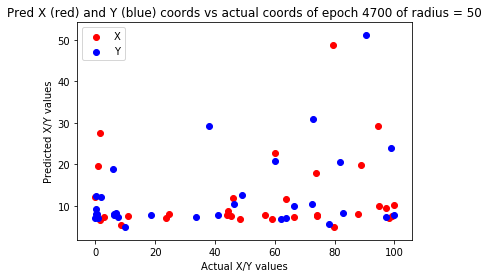

Loss of epoch 4800 = 3571.91282944656


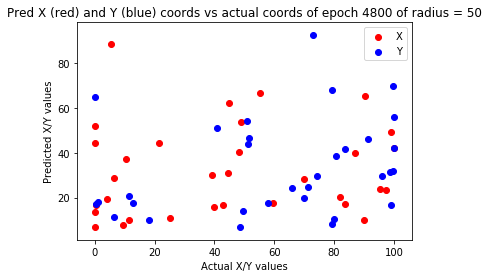

Loss of epoch 4900 = 4810.2865673887245


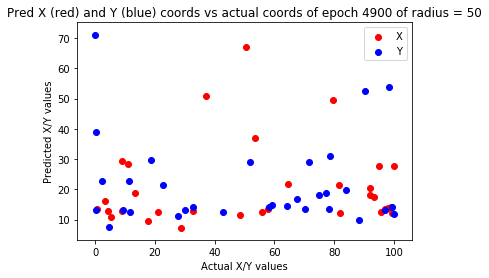

Loss of epoch 5000 = 4128.658443338152


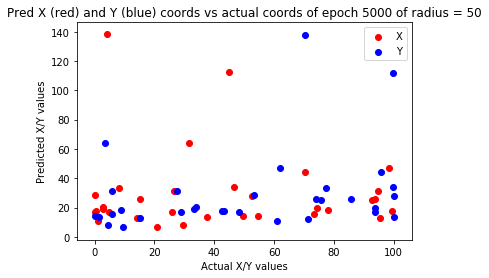

Loss of epoch 5100 = 3728.0536044205783


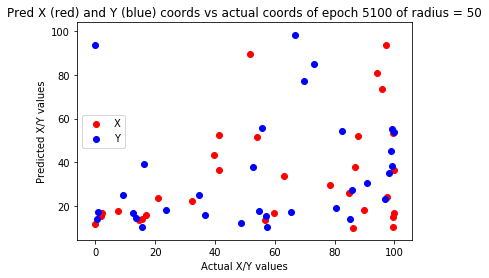

Loss of epoch 5200 = 4133.851093078929


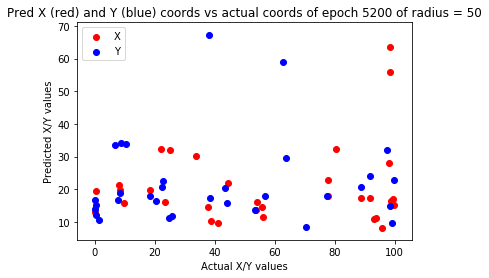

Loss of epoch 5300 = 3933.9081802343017


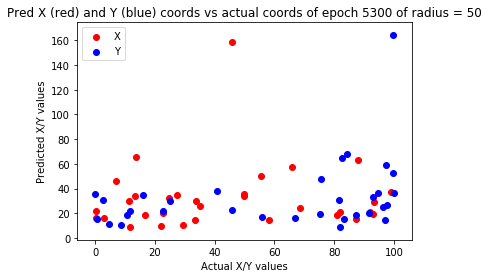

Loss of epoch 5400 = 5183.9142896585545


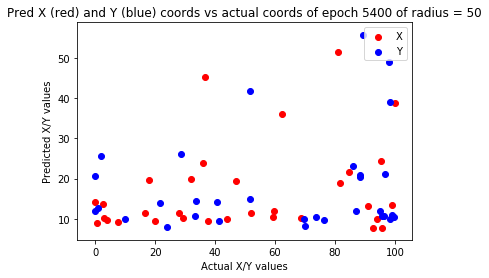

Loss of epoch 5500 = 3313.8243212342195


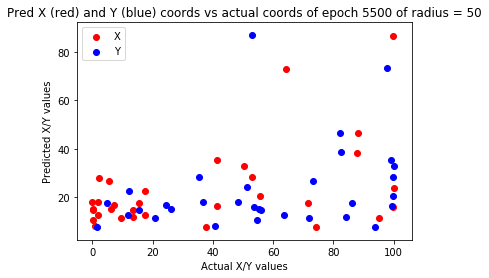

Loss of epoch 5600 = 4342.755940988983


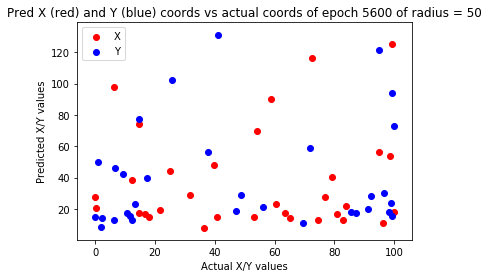

Loss of epoch 5700 = 10702.211853397857


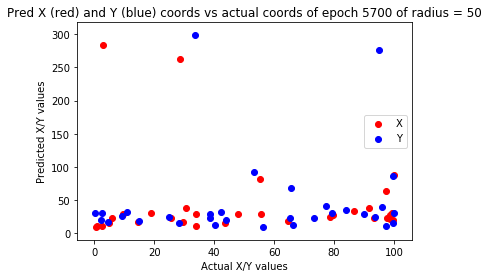

Loss of epoch 5800 = 3758.8367602706303


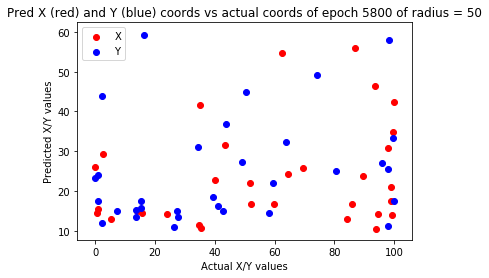

Loss of epoch 5900 = 4290.63254087938


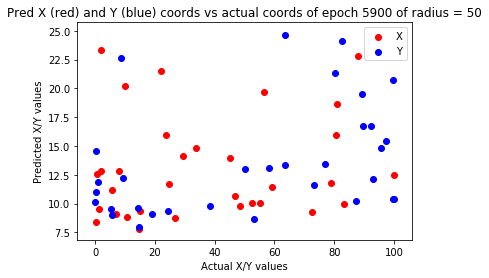

Loss of epoch 6000 = 13842.87001865959


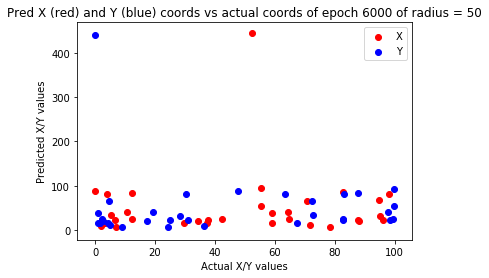

Loss of epoch 6100 = 4064.220005519852


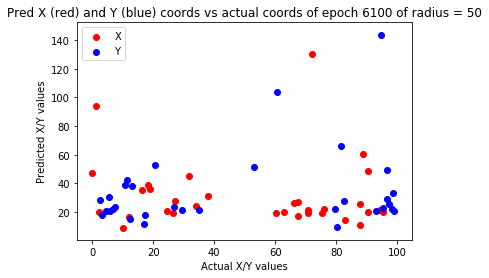

Loss of epoch 6200 = 2882.838622554942


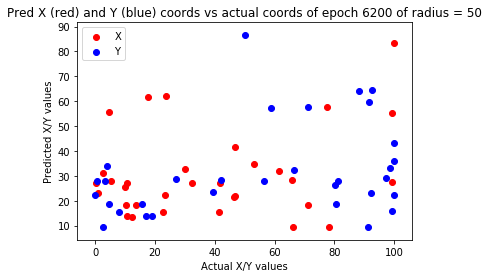

Loss of epoch 6300 = 4700.304922602756


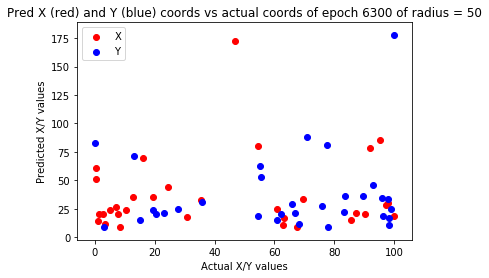

Loss of epoch 6400 = 6221.898283981099


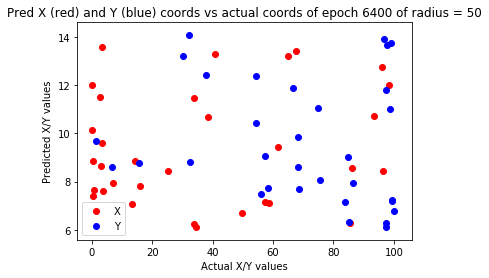

Loss of epoch 6500 = 4894.015935329244


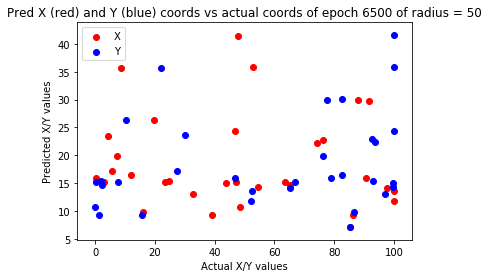

Loss of epoch 6600 = 2811.2932028785854


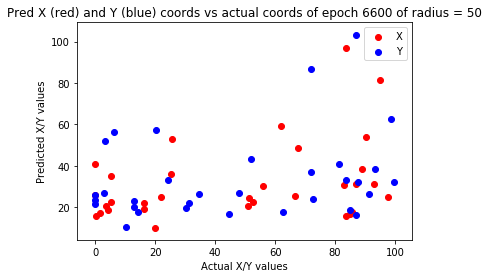

Loss of epoch 6700 = 4781.067564022831


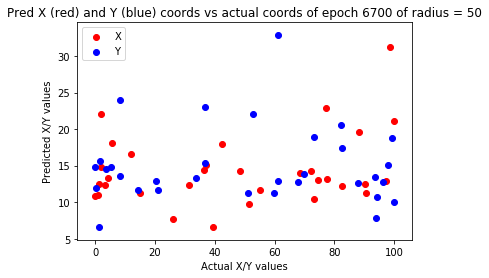

Loss of epoch 6800 = 3500.038486329341


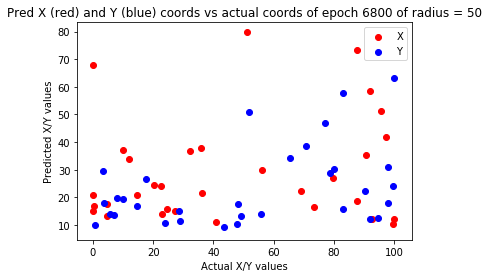

Loss of epoch 6900 = 4029.7860442092524


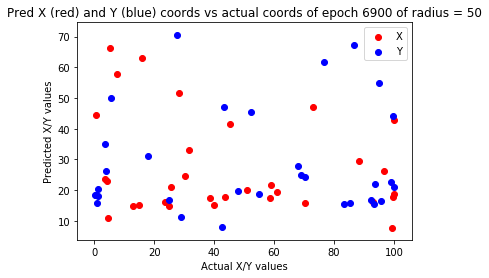

In [2]:
from network import SimpleNet as SimpleNet

roomSim = Simulation(SAMPLE_RATE, RAD, ABSORPTION, MIC_L_DIST, MIC_R_DIST, NR_MICS)
dataset = SineData(BATCH_SIZE, roomSim, TIME, MIN_LENGTH, 20, MAX_FREQ)

if EPOCHS > 0:
    net = SimpleNet(MIN_LENGTH)
    net = net.double().to(device)
    criterion = nn.MSELoss()
    optimiser = torch.optim.Adam(net.parameters())
    logger = Logger("./logs", "MSE")
    dataLoader = DataLoader(dataset, batch_size=BATCH_SIZE)

    for curEpoch in range(EPOCHS):
        # Reset seed so random sine data is generated, otherwise RNG is repeated
        np.random.seed()

        # Gather input data & labels
        inL, inR, labelX, labelY, _ = next(iter(dataLoader))
#         inL, inR, _, _, labelAzi = next(iter(dataLoader))
        inL = inL.double().to(device)
        inR = inR.double().to(device)
#         labelAzi = labelAzi.double().to(device)
        labelX = labelX.double().to(device)
        labelY = labelY.double().to(device)

        # Training loop
        optimiser.zero_grad()
        outputX, outputY = net(inL, inR)
        loss = criterion(torch.squeeze(outputX), labelX) + criterion(torch.squeeze(outputY), labelY)
        loss.backward()
        optimiser.step()

        if curEpoch % STEP_SIZE == 0: 
            # Log loss in tensorboard as scalars
            logger.scalar_summary("loss", loss.item(), curEpoch)

            outputXnp = outputX.detach().cpu().numpy()
            outputYnp = outputY.detach().cpu().numpy()
            labelXnp = labelX.detach().cpu().numpy()
            labelYnp = labelY.detach().cpu().numpy()

            # Plot the predicted vs actual angles
            if curEpoch % 100 == 0:
                print("Loss of epoch "+str(curEpoch)+" = "+str(loss.item()))
                
                plt.scatter(labelXnp, outputXnp, c="red", label = "X")
                plt.scatter(labelYnp, outputYnp, c="blue", label = "Y")
                plt.title("Pred X (red) and Y (blue) coords vs actual coords of epoch " + str(curEpoch) + " of radius = " + str(RAD))
                plt.xlabel("Actual X/Y values")
                plt.ylabel("Predicted X/Y values")
                plt.legend()
                plt.show()

#                 plt.title("Pred X (red) and Y (blue) coords vs actual coords of epoch " + str(curEpoch) + " of radius = " + str(RADII[i]))
#                 plt.xlabel("Actual X/Y values")
#                 plt.ylabel("Predicted X/Y values")
#                 plt.legend()
#                 plt.show()
#                 plt.scatter(labelAzinp, outputnp)
#                 plt.title("Pred azi vs actual azi of epoch "+str(curEpoch)+" of radius = "+str(RAD))
#                 plt.xlabel("Actual azi")
#                 plt.ylabel("Predic azi")
#                 plt.show()

            # Log gradients and weights in tensorboard as distributions and histograms
            for tag, value in net.named_parameters():
                tag = tag.replace('.', '/')
                logger.histo_summary(tag, value.data.cpu().numpy(), curEpoch)
                logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), curEpoch)

                # Log gradient of last layer as scalar
                if "fc" in tag and "weight" in tag:
                    last_grad_norm = np.sqrt(np.mean(np.square(value.grad.data.cpu().numpy())))
                    logger.scalar_summary("last_grad_norm", last_grad_norm, curEpoch)

        curEpoch += 1

    torch.save(net.state_dict(), "SimpleNet_MSELoss")

